In [224]:
import os
import numpy as np
import scipy.io as sio
import natsort as n
import matplotlib.pyplot as plt

In [225]:
def get_mouse_data_and_score(mouseid, tag='Psyco_all', rootdir='/home/anverdie/Documents/Analysis/'):
    """ Simple function to extract data from matlab recordings
    """
    
    path = [os.path.join(rootdir, 'M' + mouseid, path, 'Stims.mat') for path in os.listdir(os.path.join(rootdir, 'M' + mouseid))]
    
    datafiles = [sio.loadmat(p) for p in path if os.path.exists(p) and tag in p]
    
    if len(datafiles):
        corrs, stims, outs = [], [], []
        for i, data in enumerate(datafiles):

            stims.append(data['ExperimentInfo']['TrialSequence'][0][0][0])
            corrs.append(data['ExperimentInfo']['Correct'][0][0][0])
            outs.append(data['ExperimentInfo']['OutComeTrials'][0][0][0])

        stims = np.array([i for s in stims for i in s])
        corrs = np.array([i for s in corrs for i in s])
        outs = np.array([i for s in outs for i in s])

        scores = {}
        for t in np.arange(3, 17):
            curr_stim = np.where(stims == t)[0]
            scores[t] = np.sum(corrs[curr_stim])/len(curr_stim)

        scs = [1 - scores[k] for k in scores]

        idx_gos = np.where(stims == 1)[0]
        idx_nogos = np.where(stims == 2)[0]
        idx_blank = np.where(stims == 0)[0]
        
        go_score = np.sum(corrs[idx_gos])/len(idx_gos)
        nogo_score = np.sum(corrs[idx_nogos])/len(idx_nogos)
        blank_score = np.sum(corrs[idx_blank])/len(idx_blank)
        
        scs = [go_score] + scs + [1 - nogo_score]
        data = {}
        data['raw_scores'] = scores
        data['go_score'] = go_score
        data['nogo_score'] = nogo_score
        data['blank_score'] = blank_score
        data['scores'] = scs
        
       
        return data

In [226]:
def get_stims(tag, rootdir='/home/anverdie/Documents/Analysis/Stims'):
    """ Load stims numpy array depending on tag
    """
    stims = [np.load(os.path.join(rootdir, f)) for f in n.natsorted(os.listdir(rootdir)) if tag in f]
    names = [f[:-4] for f in n.natsorted(os.listdir(rootdir)) if tag in f]
    return stims, names

In [227]:
import tensorflow.keras as keras
from tensorflow.keras import backend as K
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D


def blur_stim(stims_to_blur, sigma=np.sqrt(np.log(2)/2), ksize=3):
    """ Default sigma is considering 1px = 150um
    """
    opt = keras.optimizers.Adam(learning_rate=0.0001)
    x, y = np.meshgrid(np.linspace(-1, 1, ksize), np.linspace(-1, 1, ksize))
    dst = np.sqrt(x*x + y*y)
    muu = 0.000
    
    kernel_weights = np.exp(-((dst-muu)**2 / (2.0 * sigma**2)))
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)
    kernel_weights = np.repeat(kernel_weights, 1, axis=-1)
    kernel_weights = np.expand_dims(kernel_weights, axis=-1)

    def gaussian_blur_filter(shape, dtype=None):
        f = np.array(kernel_weights)

        assert f.shape == shape
        return K.variable(f, dtype='float32')

    gaussian_blur = Conv2D(1, (ksize, ksize), use_bias=False, kernel_initializer=gaussian_blur_filter, padding='same', trainable=False, name='gaussian_blur')

    Blurring_Model = Sequential(
        gaussian_blur
    )
    
    blurred_stims = [Blurring_Model(s.reshape(1, 10, 10, 1)).numpy() for s in stims_to_blur]
    
    return blurred_stims

In [228]:
# Retrieve data for mouse depending on task
m1 = get_mouse_data_and_score('786658', tag='Psyco_all_')
m2 = get_mouse_data_and_score('786656', tag='Psyco_all_')

m1_am = get_mouse_data_and_score('786658', tag='Psyco_allam_')
m2_am = get_mouse_data_and_score('786656', tag='Psyco_allam_')

(-0.1, 1.1)

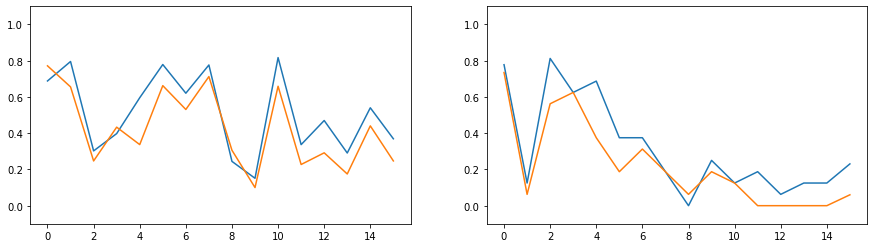

In [229]:
# Plot prob of lick of the two tasks
fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(m2['scores'])
axs[0].plot(m1['scores'])
axs[0].set_ylim(-0.1, 1.1)

axs[1].plot(m2_am['scores'])
axs[1].plot(m1_am['scores'])
axs[1].set_ylim(-0.1, 1.1)

In [230]:
stims, names = get_stims('PT')
stims_am, names_am = get_stims('AM')

# Correct for stims_am since go is PT
stims_am[0], stims_am[-1] = stims[0], stims[-1]
names_am[0], names_am[-1] = names[0], names[-1]

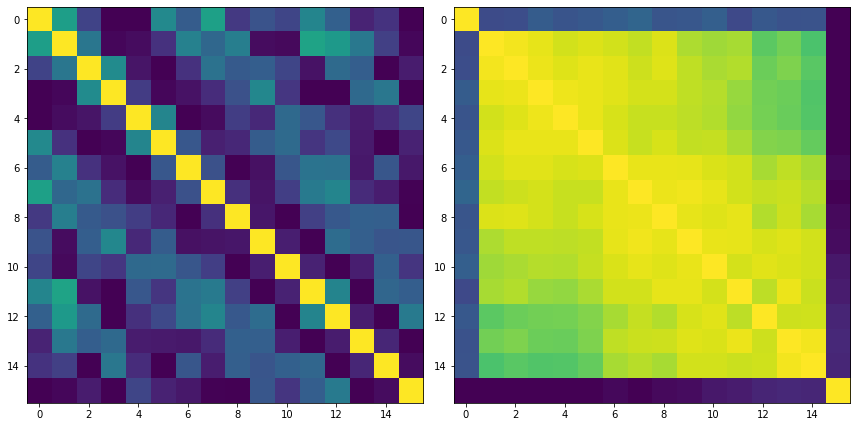

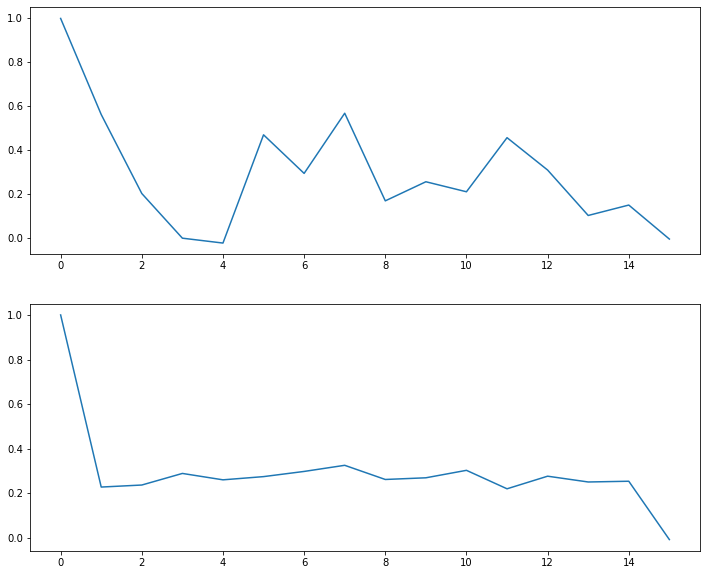

In [231]:
# Plot autocorr matrices
fig, axs = plt.subplots(1, 2, figsize=(12, 10))
corr_matrix = np.corrcoef(np.array([s.flatten() for s in stims]))
corr_matrix_am = np.corrcoef(np.array([s.flatten() for s in stims_am]))

go_corr = corr_matrix[0, :]
go_corr_am = corr_matrix_am[0, :]

axs[0].imshow(corr_matrix, vmin=0, vmax=1)
axs[1].imshow(corr_matrix_am, vmin=0, vmax=1)

plt.tight_layout()
plt.show()
plt.close()

fig, axs = plt.subplots(2, figsize=(12, 10))

axs[0].plot(go_corr)
axs[1].plot(go_corr_am)


In [232]:
ksizes = np.arange(2, 14, 2)
sigmas = np.linspace(0.2, 0.9, 30)

print('Trying kernel sizes :', ksizes)
print('Trying sigmas :', sigmas)


correlation_to_go = {}
for k in ksizes:
    for s in sigmas:
        blurred_stims = blur_stim(stims, ksize=k, sigma=s)
        corrm = np.corrcoef(np.array([bs.flatten() for bs in blurred_stims]))
        key = '{}_{:02f}'.format(k, s)
        correlation_to_go[key] = corrm[0, :]
        

Trying kernel sizes : [ 2  4  6  8 10 12]
Trying sigmas : [0.2        0.22413793 0.24827586 0.27241379 0.29655172 0.32068966
 0.34482759 0.36896552 0.39310345 0.41724138 0.44137931 0.46551724
 0.48965517 0.5137931  0.53793103 0.56206897 0.5862069  0.61034483
 0.63448276 0.65862069 0.68275862 0.70689655 0.73103448 0.75517241
 0.77931034 0.80344828 0.82758621 0.85172414 0.87586207 0.9       ]
180


0.057792868067035805

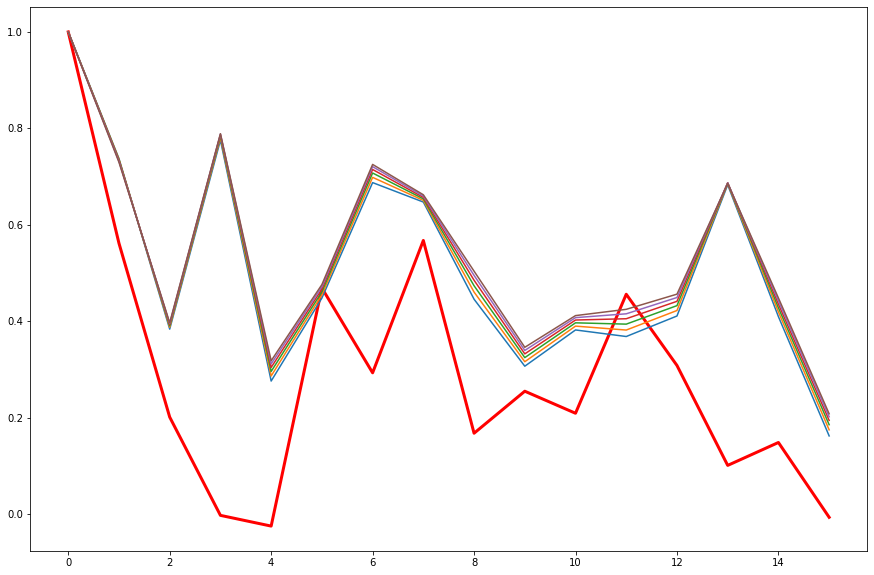

In [239]:
import tensorflow as tf

plt.figure(figsize=(15, 10))

plt.plot(go_corr, color='red', linewidth=3)
errs = {}
for k in correlation_to_go:
    err = tf.keras.losses.mean_squared_error(m2['scores'], correlation_to_go[k]).numpy()
    errs[k] = err
    if err < 0.06: plt.plot(correlation_to_go[k])

min(errs.values())
# Correlation doesn't seem to explain enough the discrepencies